## Implementation Details SoPhie

1. Feature Extractor Module
2. Attention Module
3. LSTM based GAN Module
4. Loss
5. Optimizer

# 1. Feature Extractor Module

### 1.1 Visual Features
- $V_{Ph}^t = CNN(I^t; W_{cnn})$
- Fine tuned on scene ground truth?
- Take ResNet features first, without pretraining.

### 1.2 Past Trajectory Features
- $V_{en}^t(i)= LSTM_{en}(X_i^t, h_{en}^t(i), W_{en})$
- $h_{en}^t(i)$ hidden state of the encoder at time $t$ for the agent $i$
- $V_{So}^t(i)=(V_{en}^t(\pi_j)-V_{en}^t(i) \vert \forall \pi_j \in [N]\i))$
- $\pi_j$ distance of closest agent


# 2. Attention Module

### 2.1 Physical
- $C_{Ph}^t(i)=ATT_{Ph}(V_{Ph}, h_{dec}^t(i); W_{Ph}$) , physical

### 2.2 Social
- $C_{So}^t(i)=ATT_{So}(V_{So}^t(i), h_{dec}^t(i); W_{So}$) , social

# 3. LSTM based GAN Module
### 3.1 Generator
- Generator input $C_G^t(i) = [C_{So}^t(i), C_{Ph}^t(i), z]$
- Generator output $\hat{Y}^\tau_i = LSTM_{dev}(C_G^t(i), h_{dec}^\tau(i); W_{dec})$

### 3.2 Discriminator
- Discriminator input $T_i^{1:\tau} \sim p(\hat{Y}^{1:\tau}_i, Y^{1:\tau}_i)$ , all states up to $\tau$
- Discriminator output $\hat{L}_i^\tau = LSTM_{dis}(T_i^\tau, h_{dis}^\tau(i); W_{dis})$

## 4. Loss
$L_{GAN}(\hat{L}_i^\tau, L_i^\tau)=\min_G \max_D E_{T_i^{1:\tau} \sim p(Y^{1:\tau}_i)} [L_i^\tau \log \hat{L}_i^\tau]+ E_{T_i^{1:\tau} \sim p(\hat{Y}^{1:\tau}_i)}[(1-L_i^\tau)\log(1-\hat{L}_i^\tau)]$

$L_{L2}(\hat{Y}^{\tau}_i, Y^{\tau}_i)$

$W* = \text{argmin}_W E_{i,\tau}[L_{GAN}+ \lambda L_{L2}]$

# 5. Optimizer
- Adam optimizer
- n_batch = 64
- lr = 0.001
- n_epochs = 200
- rotation and flipping
- coordinate normalization

### social attention
- emlp_dim = 16  #encoder

### gan
- ghid_dim = 32 #generate
- dhid_dim = 64 #discriminator
- dmlp_dim = 16 #decoder generator

### attention
- 4 mlp layers of sizes (64, 128, 64, 1) with relu, final softmax
- n_max = 32 else 0 # considered agents

### physical attention
- vgg 512 channels mlp to 16

### training
t_obs = 8
t_pred = 12
lambda = 1
- flipping, rotating scene
- coordinate normalization
- 


In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torchvision import models
from pathlib import Path
import cv2
import numpy as np
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
#root_path = Path('/mnt/Clouds/MultimodalSophie/')
root_path = Path('/home/yy/ADL4CV/mapsgan/')


class Experiment:
    
    def __init__(self):
        super(Experiment, self).__init__()
        self.file_name = ''
        self.file_path = ''
        
class ETH(Experiment):

    def __init__(self):
        super(ETH, self).__init__()
        self.file_name = 'seq_eth.avi'
        self.file_path = root_path / 'data/ETH/ewap_dataset/seq_eth'
        self.video_file = root_path / 'data/ETH/ewap_dataset/seq_eth/seq_eth.avi'
        self.H = np.array([[2.8128700e-02,   2.0091900e-03,  -4.6693600e+00], 
           [8.0625700e-04,   2.5195500e-02,  -5.0608800e+00],
           [3.4555400e-04,   9.2512200e-05,   4.6255300e-01]])

In [3]:
class Videodata:
    
    def __init__(self, experiment):
        self.file_path = experiment.file_path
        self.file_name = experiment.file_name
        self.homography = experiment.H
        self.video = cv2.VideoCapture(str(experiment.video_file))
        self.frame_width = int(self.video.get(cv2.CAP_PROP_FRAME_WIDTH))
        self.frame_height = int(self.video.get(cv2.CAP_PROP_FRAME_HEIGHT))
        self.frame_count = int(self.video.get(cv2.CAP_PROP_FRAME_COUNT))
        
    def __getitem__(self, key):
        return NotImplemented
    
    def __len__(self):
        return NotImplemented
    
    def read_file(self, _path, delim='\t'):
        data = []
        if delim == 'tab':
            delim = '\t'
        elif delim == 'space':
            delim = ' '
        with open(_path, 'r') as f:
            for line in f:
                line = line.strip().split(delim)
                line = [float(i) for i in line]
                data.append(line)
        return np.asarray(data)
    
    def camcoordinates(self, xy):
        """Transform the meter coordinates with the homography matrix"""
        coords = xy.reshape(1, 1, -1)
        return cv2.perspectiveTransform(coords,  np.linalg.inv(self.homography)).squeeze()[::-1]
    
    def getFrame(self, fid):
        self.video.set(cv2.CAP_PROP_POS_FRAMES,fid)
        return self.video.read()[1]
    
    def staticImage(self):
        ret = True
        image = np.zeros((self.frame_height, self.frame_width, 3))
        while(ret):
            ret, img = self.video.read()
            if not ret:
                break
            image += img
        image /= self.frame_count
        image = image.astype('uint8')
        return image
        
    

In [4]:
e = ETH()

In [5]:
V = Videodata(e)

In [7]:
# traj = V.read_file('/mnt/Clouds/MultimodalSophie/sgan/datasets/eth/test/biwi_eth.txt')
traj = V.read_file('/home/yy/ADL4CV/sgan/datasets/eth/test/biwi_eth.txt')


In [8]:
traj[np.where(traj[:, 1]==300)]

array([[  1.06700000e+04,   3.00000000e+02,   4.91000000e+00,
          6.78000000e+00],
       [  1.06800000e+04,   3.00000000e+02,   5.80000000e+00,
          6.51000000e+00],
       [  1.06900000e+04,   3.00000000e+02,   6.72000000e+00,
          6.21000000e+00],
       [  1.07000000e+04,   3.00000000e+02,   7.64000000e+00,
          5.92000000e+00],
       [  1.07100000e+04,   3.00000000e+02,   8.60000000e+00,
          5.70000000e+00],
       [  1.07200000e+04,   3.00000000e+02,   9.51000000e+00,
          5.42000000e+00],
       [  1.07300000e+04,   3.00000000e+02,   1.04300000e+01,
          5.18000000e+00],
       [  1.07400000e+04,   3.00000000e+02,   1.13400000e+01,
          5.14000000e+00],
       [  1.07500000e+04,   3.00000000e+02,   1.22300000e+01,
          5.09000000e+00],
       [  1.07600000e+04,   3.00000000e+02,   1.34000000e+01,
          5.20000000e+00]])

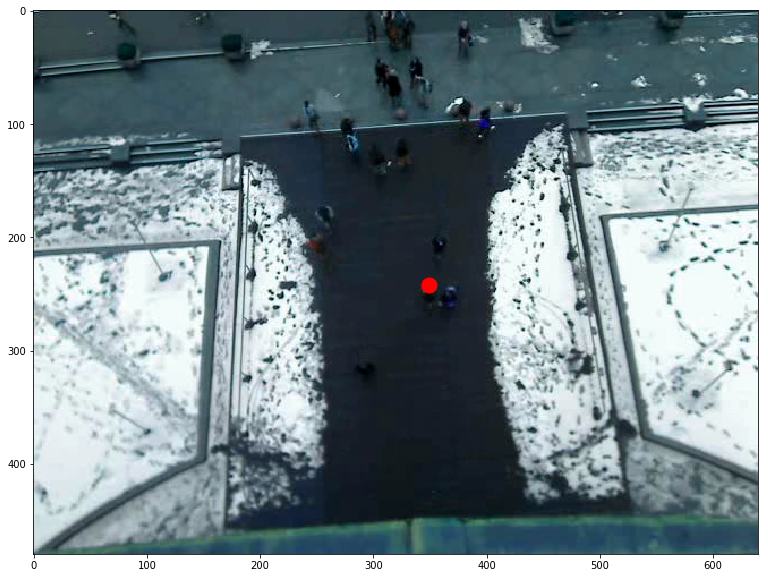

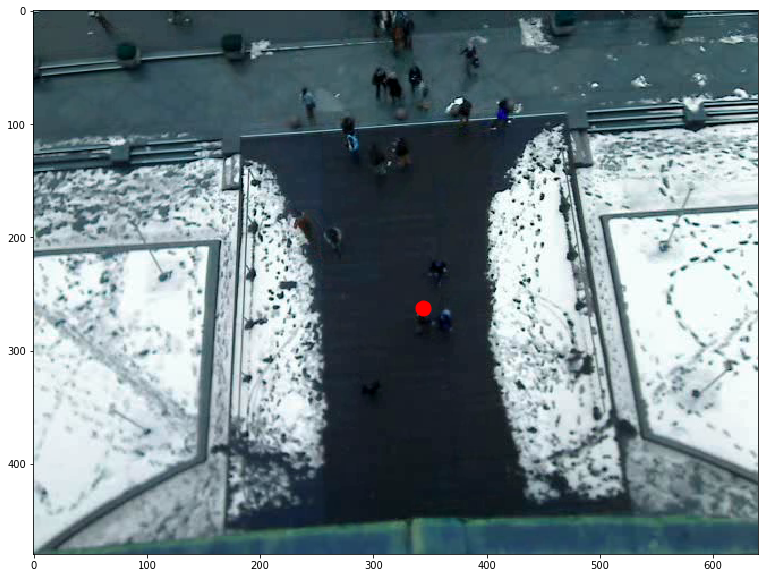

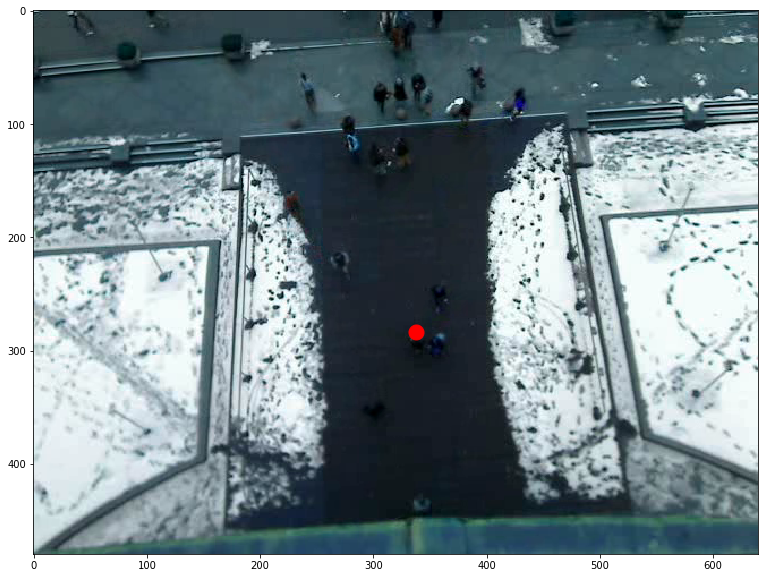

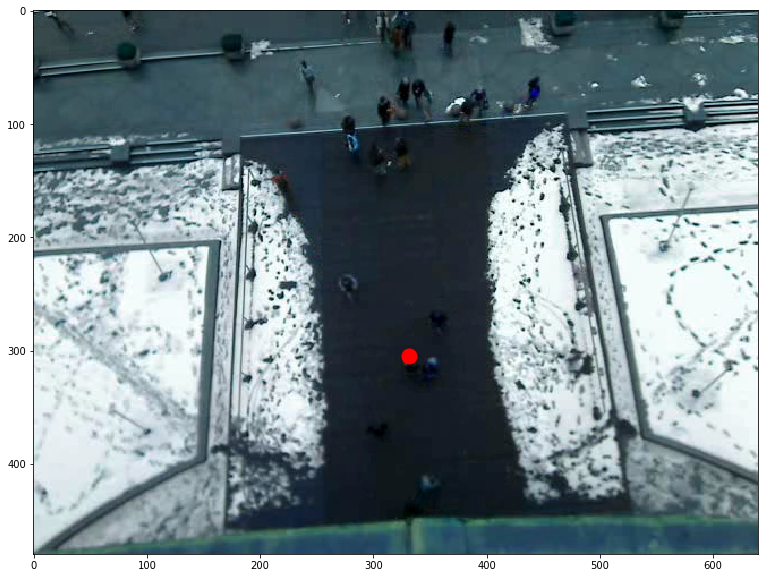

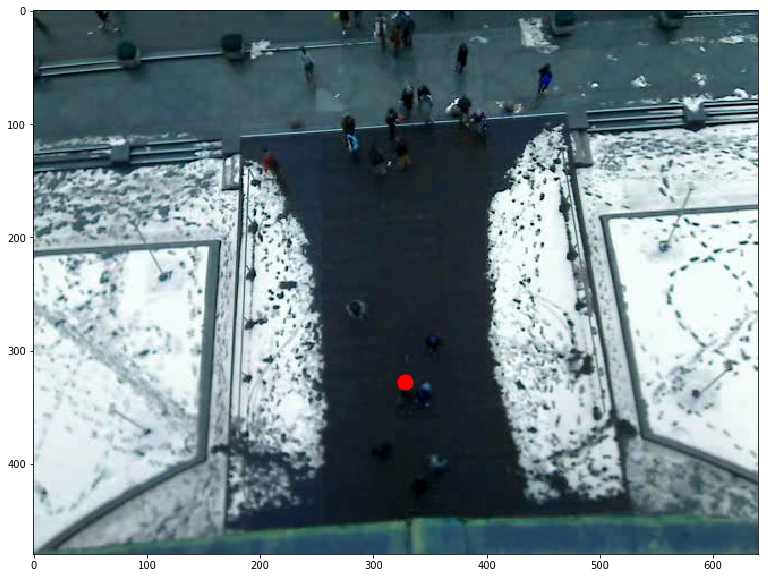

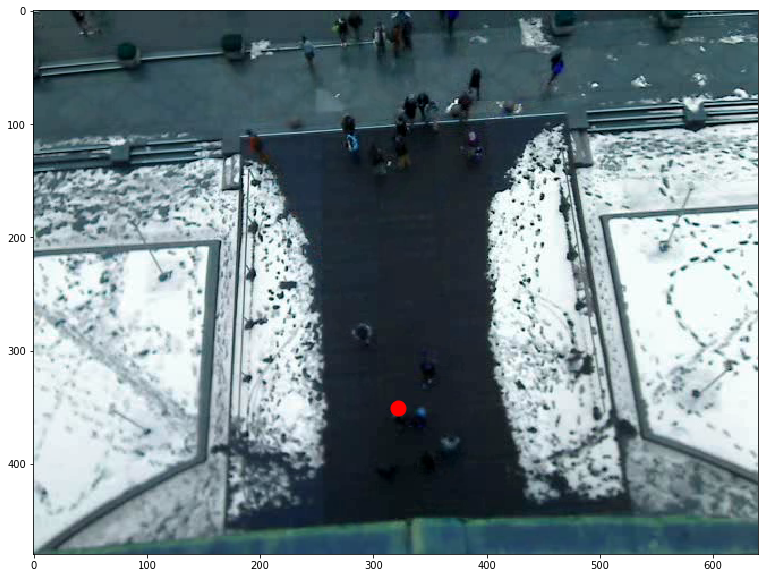

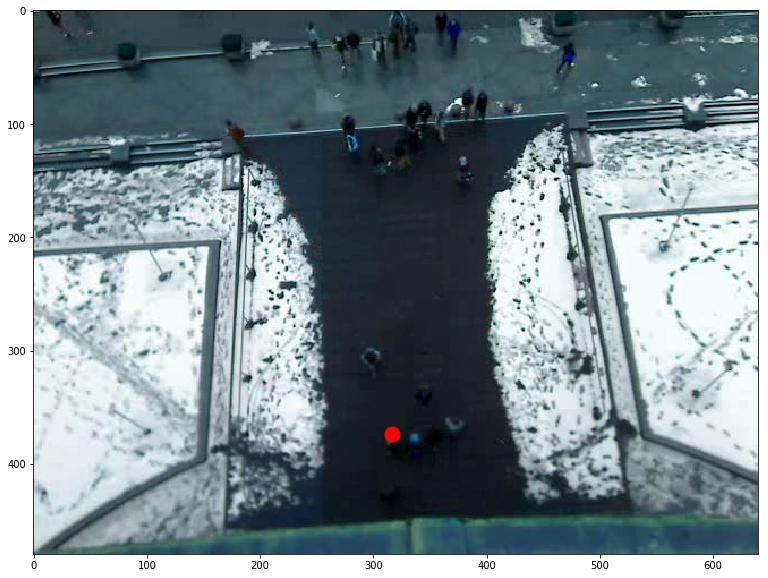

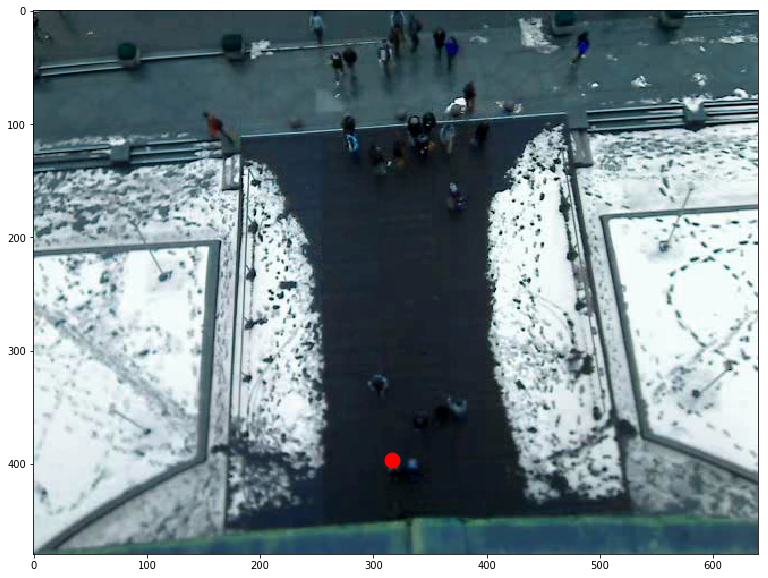

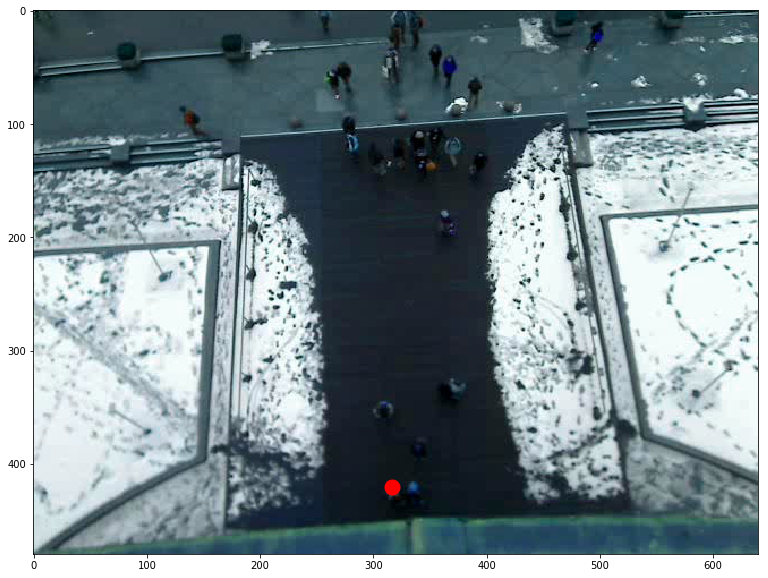

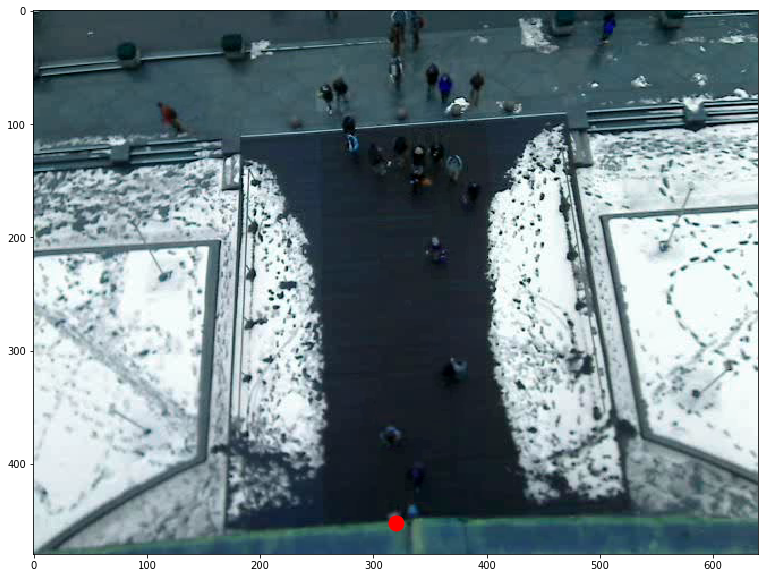

In [12]:
for t in traj[np.where(traj[:, 1]==300)]:
    frame, aid, x, y = t
    fig, ax = plt.subplots(1, 1, figsize = [20, 10])
    ax.imshow(V.getFrame(frame))
    ax.plot(*V.camcoordinates(np.array([x, y])), 'r.', markersize = 30)
    plt.show()

In [34]:
transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                              
                                transforms.ToTensor()])

In [37]:
e = ETH()
V = Videodata(e)
x = V.staticImage()

In [68]:
img = transform(Image.fromarray(x))

In [69]:
img.unsqueeze(0)


( 0 , 0 ,.,.) = 
  0.1490  0.1529  0.1569  ...   0.1765  0.1765  0.1725
  0.1373  0.1373  0.1412  ...   0.1882  0.1922  0.1961
  0.1412  0.1412  0.1412  ...   0.1882  0.1961  0.2039
           ...             ⋱             ...          
  0.4941  0.5176  0.5294  ...   0.1020  0.1020  0.0980
  0.4902  0.5255  0.5529  ...   0.1412  0.1412  0.1412
  0.5216  0.5725  0.5686  ...   0.1725  0.1765  0.1843

( 0 , 1 ,.,.) = 
  0.2314  0.2314  0.2353  ...   0.2863  0.2863  0.2824
  0.2275  0.2275  0.2275  ...   0.2941  0.2980  0.3059
  0.2196  0.2196  0.2196  ...   0.2941  0.3020  0.3098
           ...             ⋱             ...          
  0.5529  0.5765  0.5922  ...   0.1961  0.1961  0.1961
  0.5490  0.5882  0.6157  ...   0.2667  0.2706  0.2667
  0.5843  0.6314  0.6314  ...   0.3686  0.3725  0.3804

( 0 , 2 ,.,.) = 
  0.2549  0.2588  0.2627  ...   0.3137  0.3137  0.3137
  0.2471  0.2510  0.2549  ...   0.3216  0.3294  0.3333
  0.2353  0.2392  0.2392  ...   0.3255  0.3333  0.3412
           

In [63]:
class ResNetFeatures(nn.Module):

    def __init__(self):
        super(ResNetFeatures, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        
    def forward(self, img):
        img = self.resnet.conv1(img.unsqueeze(0))
        img = self.resnet.bn1(img)
        img = self.resnet.relu(img)
        img = self.resnet.maxpool(img)
        img = self.resnet.layer1(img)
        img = self.resnet.layer2(img)
        img = self.resnet.layer3(img)
        img = self.resnet.layer4(img)
        return img


In [67]:
R = ResNetFeatures()
R.forward(img)

TypeError: argument 0 is not a Variable

In [66]:
resnet = models.resnet18(pretrained = True)

reassign_layers(resnet)

resnet.forward = _forward.__get__(resnet, resnet.__class__)

resnet.extract_layers = ['layer9']

#plt.imshow(feat_resnet[50])

In [ ]:
feat

In [ ]:
vgg = models.vgg16(pretrained = True)
reassign_layers(vgg)
vgg.forward = _forward.__get__(vgg, vgg.__class__)
vgg.extract_layers = ['layer13']
feat_vgg = vgg(img.unsqueeze(0))['layer13'].squeeze().data.numpy()
plt.imshow(feat_vgg[50])